# Study on (tailcut) cleaning optimisation

The idea here is to define a benchmark to optimise cleaning independently of any reconstruction that would come **after**.    
In my opinion, optimising cleaning as a function of the whole reconstruction is a dangerous path as:   
- it’s tedious (you have to loop over the whole reconstruction)    
- optimising cleaning before optimising the later part of the reconstruction might end up in reaching a cleaning well adapted to the reconstruction method chosen a priori but not good in absolute. (then a different/better reconstruction might end-up showing worst results)

Since prod3b simulation include the ground thruth image in photo-electron, this could be used to optimise the cleaning as a goal. To do so, I propose to simply compute the distance between the cleaned image and the ground truth as a function of cleaning method/parameters and finding the minimum of this distance (average on many events).

This also allow to study the cleaning as a function of event info (such as energy, signal amplitude... )

Of course, this supposes that the calibration has been previously optimised.

In [1]:
from ctapipe.io import event_source
from ctapipe.utils import datasets
from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean, dilate
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import poisson
import os
from ctapipe.utils import get_dataset
import copy
import astropy.units as u
%matplotlib inline

In [2]:
def apply_cleaning(calibrated_event, cleaning, **cleaning_params):
    
    chan = 0
    
    for tel_id in calibrated_event.r0.tels_with_data:
        camera = calibrated_event.inst.subarray.tel[tel_id].camera
        image = calibrated_event.dl1.tel[tel_id].image[chan]

        # Apply image cleaning
        cleanmask = cleaning(camera, image,
                                   **cleaning_params
                                   )
        
        calibrated_event.dl1.tel[tel_id].cleaned = copy.copy(calibrated_event.dl1.tel[tel_id].image[0])
        calibrated_event.dl1.tel[tel_id].cleaned[~cleanmask] = 0
        

In [3]:
def tailcut_cleaning_accuracy(calibrated_event, picture_threshold, boundary_threshold):
    
    diff = 0
    chan = 0
    
    tailcut_params = {'picture_thresh':picture_threshold,
                  'boundary_thresh':boundary_threshold,
                  'keep_isolated_pixels':False,
                  'min_number_picture_neighbors':1,
                 }
    
            
    for tel_id in calibrated_event.r0.tels_with_data:
        camera = calibrated_event.inst.subarray.tel[tel_id].camera
        signals = calibrated_event.dl1.tel[tel_id].image[chan]
        
        apply_cleaning(calibrated_event, tailcuts_clean, **tailcut_params)

        cleaned_image = calibrated_event.dl1.tel[tel_id].cleaned
        true_image = calibrated_event.mc.tel[tel_id].photo_electron_image 

        diff += np.linalg.norm(cleaned_image - true_image)
    
    return diff

In [4]:
def tailcut_cleaning_analyse(source, picture_threshold=[2, 10, 5], min_boundary_threshold=0):
    """
    source: event_source object
    picture_threshold: list of [min, max, number of steps]
    """
    ptmin, ptmax, ptnumber = picture_threshold
    pt = np.linspace(ptmin, ptmax, ptnumber)
    
    picture_threshold = np.empty((ptnumber,ptnumber))
    boundary_threshold = np.empty((ptnumber,ptnumber))
    for i in range(ptnumber):
        picture_threshold[i] = pt
        boundary_threshold.T[i] = np.linspace(min_boundary_threshold, pt[i], ptnumber)
        
    all_diff = []
    event_energy = []
    event_dl1_amplitude = []
    event_multiplicity = []
    
    for event in source:
        cal.calibrate(event)
        diff = np.zeros((ptnumber,ptnumber))
        event_energy.append(event.mc.energy.to(u.TeV).value)
        event_multiplicity.append(len(event.r0.tels_with_data))
        for i in range(ptnumber):
            for j in range(ptnumber):
                pt = picture_threshold[i, j]
                bt = boundary_threshold[i, j]
                d = tailcut_cleaning_accuracy(event, pt, bt)
                diff[i,j]+=d
        all_diff.append(diff)
        
        amp = 0
        for tel_id in event.r0.tels_with_data:
            amp += event.dl1.tel[tel_id].image[0].sum()
        event_dl1_amplitude.append(amp)
        
    all_diff = np.array(all_diff)
    
    event_info = {'event_energy': np.array(event_energy) * u.TeV, 
                  'event_multiplicity': np.array(event_multiplicity),
                  'event_dl1_amplitude': np.array(event_dl1_amplitude)}
    
    return np.array([picture_threshold, boundary_threshold]), all_diff, event_info

In [5]:
def find_best_threshold(thresholds, all_diff):
    index = np.unravel_index(all_diff.sum(axis=0).argmin(), all_diff.sum(axis=0).shape)
    return thresholds[0][index], thresholds[1][index]

In [6]:
def plot_cleaning_analysis(thresholds, all_diff, ax=None, **kwargs):
    
    ax = plt.gca() if ax is None else ax
    
    x = thresholds[0].ravel()
    y = thresholds[1].ravel()
    z = all_diff.sum(axis=0).ravel()
    ax.tricontourf(x,y,z, 20)
    ax.set_xlabel('picture threshold')
    ax.set_ylabel('boundary threshold')
    # ax.axis('equal')
    print("Best thresholds = ", find_best_threshold(thresholds, all_diff))
    return ax

In [75]:
def analyse_all_cameras(filename, 
                        cal = CameraCalibrator(None, None, 
                                               r1_product='HESSIOR1Calibrator', 
                                               extractor_product='NeighbourPeakIntegrator'),
                       max_events = None,
                       **kwargs_tailcut_analysis):
    
    source = event_source(filename)
    
    source.max_events = max_events
    
    cam_dict = {}   
    for i, event in enumerate(source):
        if i>0:
            break  
    for tel_id in event.inst.subarray.tel:
        cam_id = event.inst.subarray.tel[tel_id].camera.cam_id
        if not cam_id in cam_dict:
            cam_dict[cam_id] = [tel_id]
        else:
            cam_dict[cam_id].append(tel_id)
    
    for cam_id in cam_dict:
        source.allowed_tels = cam_dict[cam_id]
        thresholds, all_diff, event_info = tailcut_cleaning_analyse(source, **kwargs_tailcut_analysis)
        print("Best thresholds for camera {0} are: {1}".format(cam_id, find_best_threshold(thresholds, all_diff)))
        
    return None

In [7]:
# filename = get_dataset('gamma_test.simtel.gz')
filename = '/Users/thomasvuillaume/Work/CTA/Data/Simtel/gamma_20deg_0deg_run100___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz'

In [8]:
source = event_source(filename)

In [22]:
source.allowed_tels = {36}
source.max_events = 100

In [23]:
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')

In [24]:
for i, event in enumerate(source):
    if i>0:
        break

### Visualise simple cleaning example

36


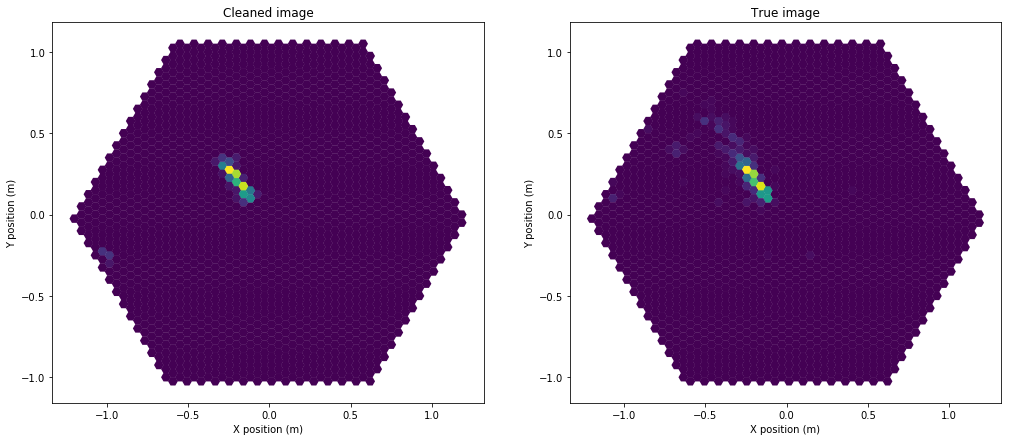

In [25]:
tailcut_params = {'picture_thresh':8,
                  'boundary_thresh':3,
                  'keep_isolated_pixels':False,
                  'min_number_picture_neighbors':1,
                 }
cal.calibrate(event)
apply_cleaning(event, tailcuts_clean, **tailcut_params)
for tel_id in event.r0.tels_with_data:
    fig, axes = plt.subplots(1, 2, figsize=(17,7))
    print(tel_id)
    CameraDisplay(event.inst.subarray.tel[tel_id].camera, event.dl1.tel[tel_id].cleaned, ax=axes[0])
    axes[0].set_title("Cleaned image")
    CameraDisplay(event.inst.subarray.tel[tel_id].camera, event.mc.tel[tel_id].photo_electron_image, ax=axes[1])
    axes[1].set_title("True image")
    plt.show()

## Run the analysis

In [26]:
thresholds, all_diff, event_info = tailcut_cleaning_analyse(source, 
                                                              picture_threshold=[2, 20, 10],
                                                             min_boundary_threshold=-5 )

In [27]:
print(thresholds.shape, all_diff.shape)
print(event_info.keys())

(2, 10, 10) (100, 10, 10)
dict_keys(['event_dl1_amplitude', 'event_energy', 'event_multiplicity'])


### Visualise the result and finding the best tailcut thresholds

Best thresholds =  (12.0, 0.6666666666666661)


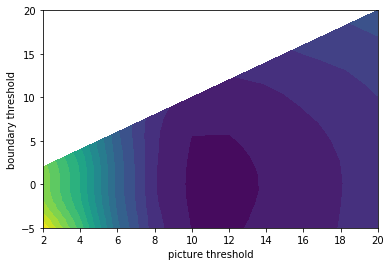

In [28]:
ax = plot_cleaning_analysis(thresholds, all_diff)

### One can also make analysis as a function of event info

#### By total event amplitude (in p.e.)

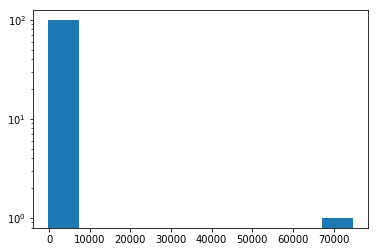

In [29]:
plt.hist(event_info['event_dl1_amplitude'], log=True);

In [30]:
mask = event_info['event_dl1_amplitude'] > 30000

Best thresholds =  (8.0, -0.666666666666667)


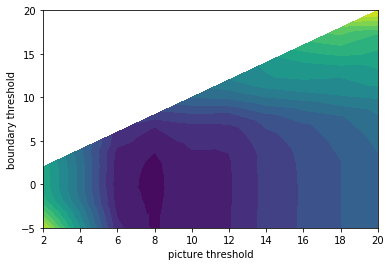

In [31]:
ax = plot_cleaning_analysis(thresholds, all_diff[mask])

#### Or by event energy

In [32]:
mask = event_info['event_energy'].value > 10

Best thresholds =  (14.0, -0.7777777777777777)


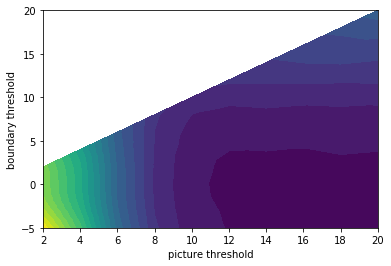

In [33]:
ax = plot_cleaning_analysis(thresholds, all_diff[mask])

## Finally one can make an analysis to find the best threshold for each camera type

In [77]:
analyse_all_cameras(filename, max_events=30, **{'picture_threshold': [2, 14, 10], 'min_boundary_threshold':-4})

Best thresholds for camera LSTCam are: (6.0, 0.44444444444444464)
Best thresholds for camera NectarCam are: (6.0, 0.44444444444444464)
Best thresholds for camera FlashCam are: (10.0, 0.666666666666667)
Best thresholds for camera SCTCam are: (3.333333333333333, 0.07407407407407351)


## Now let's try with a gradient descent

In [83]:
from scipy.optimize import minimize

In [85]:
def func(x, source=source, cal=cal):
    
    print(x)
    picture_threshold, boundary_threshold = x
    
    diff = 0
    
    for event in source:
        cal.calibrate(event)
        d = tailcut_cleaning_accuracy(event, picture_threshold, boundary_threshold)
        diff += d
        
    return d

In [82]:
source = event_source(filename)
source.max_events = 20
source.allow_tels = {1}
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')

func([6, 0])

48.71878537765093

In [97]:
minimize(func, [5, 3], method='COBYLA')

[5. 3.]
[6. 3.]
[5. 4.]
[4.00024953 2.97766176]
[4.50012476 2.98883088]
[5.24973373 2.98846474]
[5.49927161 2.97327105]
[5.74926932 2.97220186]
[5.49873701 2.8482722 ]
[5.24943138 2.82965232]
[5.60345211 2.78000984]
[5.46460584 2.79591465]
[5.52491579 2.83120661]
[5.49447062 2.8417275 ]
[5.50200936 2.846139  ]
[5.49820371 2.84745411]
[5.49914606 2.84800555]
[5.49867035 2.84816994]
[5.4987789  2.84824489]


     fun: 20.90794565388174
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 19
  status: 1
 success: True
       x: array([5.49873701, 2.8482722 ])

I honestly did not find a good minimisation method.   
It should be fairly easy, the 2D function seems convex (from the plots) and relatively well defined...    
Any help there will be welcomed